In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Aditya Bhawsar
- PRN : 250140128002
- Assignment 5

# Deep Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

## 1. Import Statements
Import all the libraries.

In [2]:
###-----------------
### Import libraries
###-----------------

import os  # Operating system-related functions and utilities
# import numpy as np  # NumPy for numerical computations
import pandas as pd  # Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib for data visualization
import seaborn as sns

# from sklearn.model_selection import train_test_split  # for train-test splitting
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report, f1_score)

import tensorflow as tf

## 2. Setup Global Parameters

In [3]:
###------------------
### Global Parameters
###------------------
RANDOM_STATE = 24
# np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
# rng = np.random.default_rng(seed=RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
ALPHA = 0.001
EPOCHS = 100
BATCH_SIZE = 32

ES_PATIENCE = 10
PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

IMG_HEIGHT = 28 # height of image
IMG_WIDTH = 28 # width of image
NUM_CHANNEL = 1 # grayscale image has one color channel

REG_LAMBDA = 0.01

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.jet

plt.rcParams.update(params)

## Input and Output and Model Directory File Path

In [4]:
# Basic Hyper-parameters

inpDir = os.path.join('/content')
outDir = os.path.join('/content')
modelDir = os.path.join('content/models')

subDir = ''
# /content/fashion-mnist_train.csv
# /content/fashion-mnist_test.csv

if not os.path.exists(outDir): # creates output folder is folder doesnot exists
    os.makedirs(outDir)

if not os.path.exists(modelDir): # creates output folder is folder doesnot exists
    os.makedirs(modelDir)

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))

In [5]:
# removes old models from gpu memory
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Helper Function

In [6]:
def fn_plot_tf_hist(train_df, test_df):

        plt.subplot(1, 2, 1)

        ax = train_df['label'].value_counts().plot(
                kind = 'bar', Title = 'Train Distribution', color = 'DarkBlue', alpha = 0.7)

        plt.subplot(1, 2, 2)

        ax = train_df['label'].value_counts().plot(
                kind = 'bar', Title = 'Test Distribution', color = 'Orange', alpha = 0.7)



In [7]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

## 3. Load Data Set

In [8]:
trainFileName = 'fashion-mnist_train.csv'
testFileName = 'fashion-mnist_test.csv'

train_df = pd.read_csv(os.path.join(inpDir, subDir, trainFileName))
test_df = pd.read_csv(os.path.join(inpDir, subDir, testFileName))

In [9]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

<Axes: xlabel='label'>

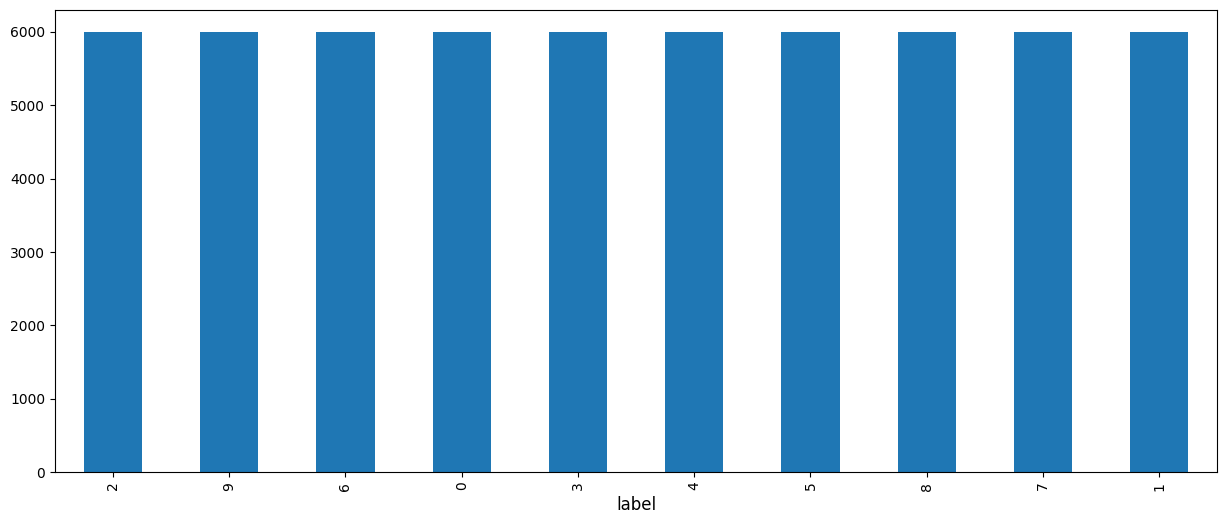

In [12]:
train_df['label'].value_counts().plot(kind='bar')

## Dataset Batch Creation

In [13]:
def fn_split_features_labels(row):
    feature = tf.reshape(row[:-1], shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL)) # shape = (28, 28, 1)
    label = row[0]
    return feature, label

In [14]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(fn_split_features_labels)
train_ds = train_ds.batch(BATCH_SIZE)

In [15]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(fn_split_features_labels)
test_ds = test_ds.batch(BATCH_SIZE)

## Sample Images

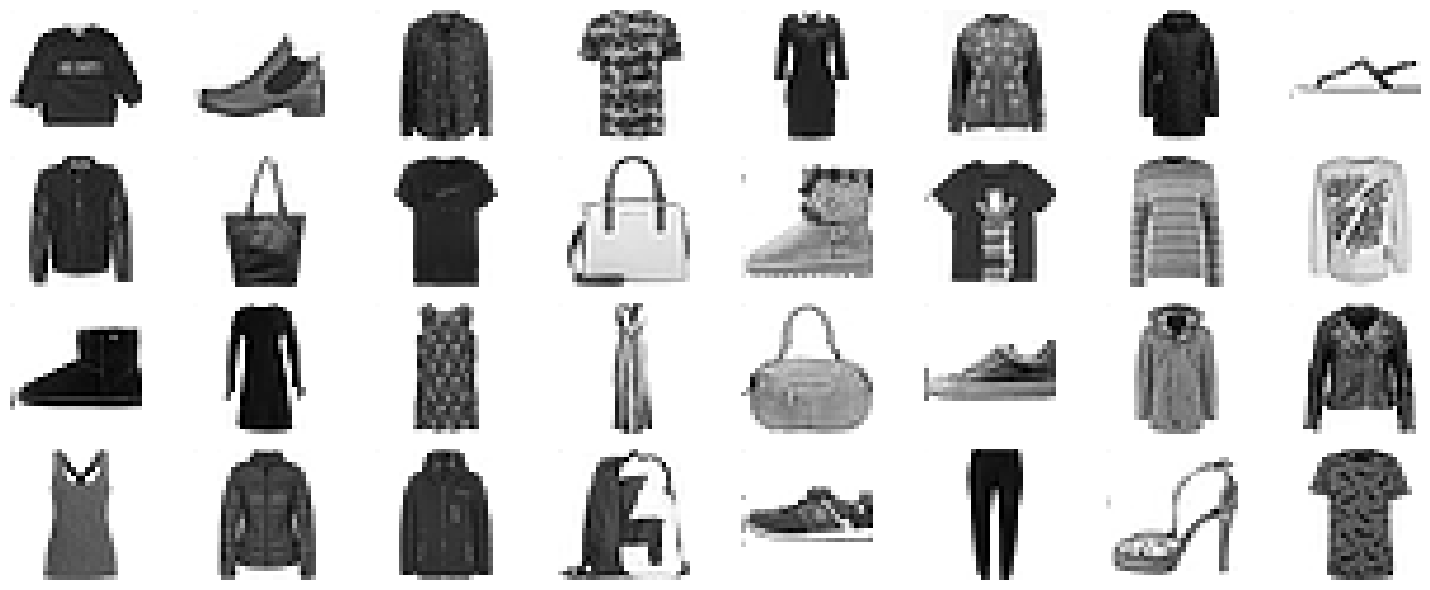

In [16]:
for images, labels in train_ds.take(1):

    for i in range(BATCH_SIZE):
        plt.subplot(4, BATCH_SIZE//4, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)

        plt.axis('off')

plt.tight_layout()

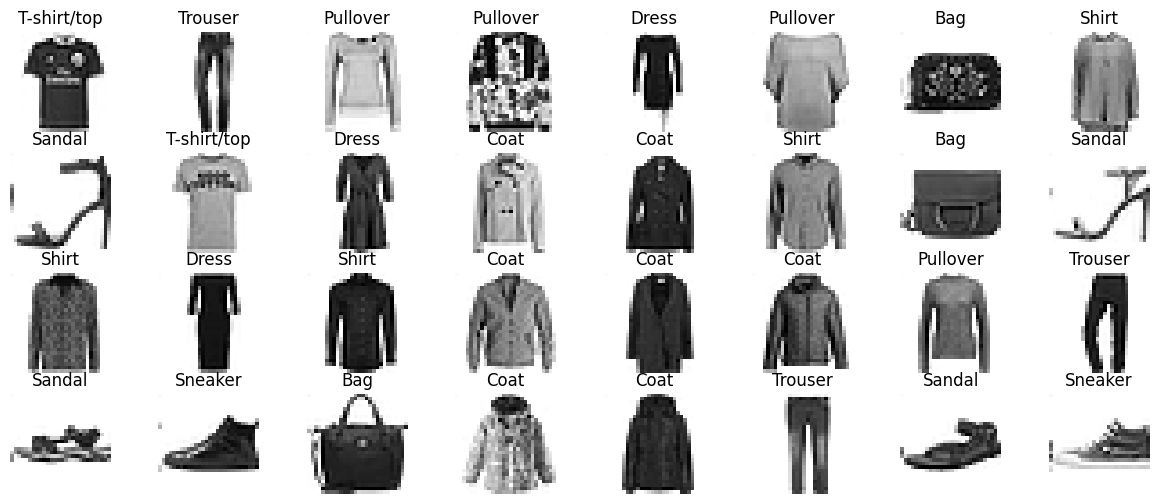

In [17]:
for images, labels in test_ds.take(1):

    for i in range(BATCH_SIZE):
        plt.subplot(4, BATCH_SIZE//4, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)
        plt.title(class_labels[labels[i].numpy()])
        plt.xlabel('Label: {}'.format(labels[i].numpy()))
        plt.axis('off')

In [18]:
imgs,lbls = next(iter(train_ds))

## Define Model

In [19]:
input_shape = imgs[0].numpy().shape
inititalizer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=input_shape))
model.add(tf.keras.layers.Rescaling(1./255))

## Set 1
# Conv1 Layers
model.add(tf.keras.layers.Conv2D(32, 3, kernel_initializer=inititalizer, # 28, 28, 32
                                 padding='same'))
# Batch Normalisation 1
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
#MaxPool 1
model.add(tf.keras.layers.MaxPool2D(2,2)) # 14, 14, 32

## Set 2
#Conv 2
model.add(tf.keras.layers.Conv2D(64, 3, kernel_initializer=inititalizer)) # 12, 12, 64
# Batch Normalisation 1
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# Maxpool 1
model.add(tf.keras.layers.MaxPool2D(2,2))   # 6, 6, 64

#Conv 3
model.add(tf.keras.layers.Conv2D(128, 3, kernel_initializer=inititalizer)) # 4, 4, 128


# Flatten Layers
model.add(tf.keras.layers.Flatten()) # 2048

# Dense Layers
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=inititalizer)) # 64
model.add(tf.keras.layers.Dense(10, kernel_initializer=inititalizer)) # 10

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,842 (878.29 KB)

 Trainable params: 224,650 (877.54 KB)

 Non-trainable params: 192 (768.00 B)

In [20]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=ES_PATIENCE,
                                               restore_best_weights=False,
                                               )

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=LR_FACTOR,
                                                   patience=LR_PATIENCE,
                                                   verbose=2,
                                                   min_lr=1e-6,)

In [21]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    verbose=2,
                    callbacks=[es_callback, lr_callback])

Epoch 1/100
1875/1875 - 15s - 8ms/step - accuracy: 0.8586 - loss: 0.3985 - val_accuracy: 0.8780 - val_loss: 0.3329 - learning_rate: 1.0000e-03
Epoch 2/100
1875/1875 - 8s - 4ms/step - accuracy: 0.9010 - loss: 0.2720 - val_accuracy: 0.8910 - val_loss: 0.3000 - learning_rate: 1.0000e-03
Epoch 3/100
1875/1875 - 12s - 6ms/step - accuracy: 0.9141 - loss: 0.2359 - val_accuracy: 0.8867 - val_loss: 0.3173 - learning_rate: 1.0000e-03
Epoch 4/100
1875/1875 - 8s - 4ms/step - accuracy: 0.9241 - loss: 0.2082 - val_accuracy: 0.8949 - val_loss: 0.2991 - learning_rate: 1.0000e-03
Epoch 5/100
1875/1875 - 8s - 4ms/step - accuracy: 0.9320 - loss: 0.1845 - val_accuracy: 0.9038 - val_loss: 0.2741 - learning_rate: 1.0000e-03
Epoch 6/100
1875/1875 - 11s - 6ms/step - accuracy: 0.9375 - loss: 0.1670 - val_accuracy: 0.9029 - val_loss: 0.2915 - learning_rate: 1.0000e-03
Epoch 7/100
1875/1875 - 9s - 5ms/step - accuracy: 0.9446 - loss: 0.1518 - val_accuracy: 0.9156 - val_loss: 0.2629 - learning_rate: 1.0000e-03
Epo

## Tracking Model Training

In [22]:
loss_df = pd.DataFrame(history.history)
loss_df.sort_values(by='val_loss', ascending=False).head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
17,0.975583,0.066406,0.8812,0.504774,0.001
16,0.972083,0.073704,0.9047,0.418470,0.001
13,0.969883,0.083645,0.8966,0.407689,0.001
14,0.970550,0.079716,0.9134,0.390368,0.001
15,0.972400,0.074536,0.9085,0.373198,0.001


In [23]:
def fn_plot_tf_hist(hist_df):
        fig, axes = plt.subplots(1, 2, figsize = (15, 5))

        y1 = hist_df.columns[0]
        y2 = hist_df.columns[1]
        y3 = hist_df.columns[2]
        y4 = hist_df.columns[3]

        best = hist_df[hist_df[y4] == hist_df[y4].min()]
        props = dict (boxstyle = 'round', facecolor = 'cyan', alpha = 0.4)
        facecolor = 'cyan'
        fontsize = 12
        CMAP = plt.cm.coolwarm

        ax = axes[0]
        hist_df.plot(y=[y2, y4], ax=ax, colormap= CMAP)
        txtFmt = 'Loss:\n   train: {:6.4f}\n    test: {:6.4f}'
        txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                        hist_df.iloc[-1][y4])

        ax.text(0.3, 0.95, txtstr,
                transform=ax.transAxes,
                fontsize = fontsize,
                verticalalignment = 'top',
                bbox = props)

        # Arrow offset markings
        y_min = min(hist_df[y2].min(), hist_df[y4].min())
        y_max = max(hist_df[y2].max(), hist_df[y4].max())
        offset = (y_max - y_min)/10.0

        ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4}', # text to print
                xy = (best.index.to_numpy(), best[y4].to_numpy()[0]), #start
                xytext = (best.index.to_numpy(), best[y4].to_numpy()[0]+offset),
                fontsize=fontsize, va = 'bottom', ha='right', bbox=props,
                arrowprops = dict(facecolor = facecolor, shrink=0.05)
                )
        ax.axvline(best.index.to_numpy(), color='g',
                linestyle = '-.', lw = 3,
                )
        ax.set_xlabel('Epochs')
        ax.set_ylabel(y2.capitalize())

        ax = axes[1]
        hist_df.plot(y=[y1, y3], ax=ax, colormap= CMAP)
        txtFmt = 'Loss:\n   train: {:6.4f}\n    test: {:6.4f}'
        txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                        hist_df.iloc[-1][y3])

        ax.text(0.3, 0.2, txtstr,
                transform=ax.transAxes,
                fontsize = fontsize,
                verticalalignment = 'top',
                bbox = props)

        # Arrow offset markings
        y_min = min(hist_df[y1].min(), hist_df[y3].min())
        y_max = max(hist_df[y1].max(), hist_df[y3].max())
        offset = (y_max - y_min)/10.0

        ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4}', # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]), #start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0]+offset),
                fontsize=fontsize, va = 'bottom', ha='right', bbox=props,
                arrowprops = dict(facecolor = facecolor, shrink=0.05)
                )

        ax.axvline(best.index.to_numpy(), color='g',
                linestyle = '-.', lw = 3,
                )

        ax.set_xlabel('Epochs')
        ax.set_ylabel(y2.capitalize())
        ax.grid()
        plt.suptitle('Training Performance')
        plt.tight_layout()

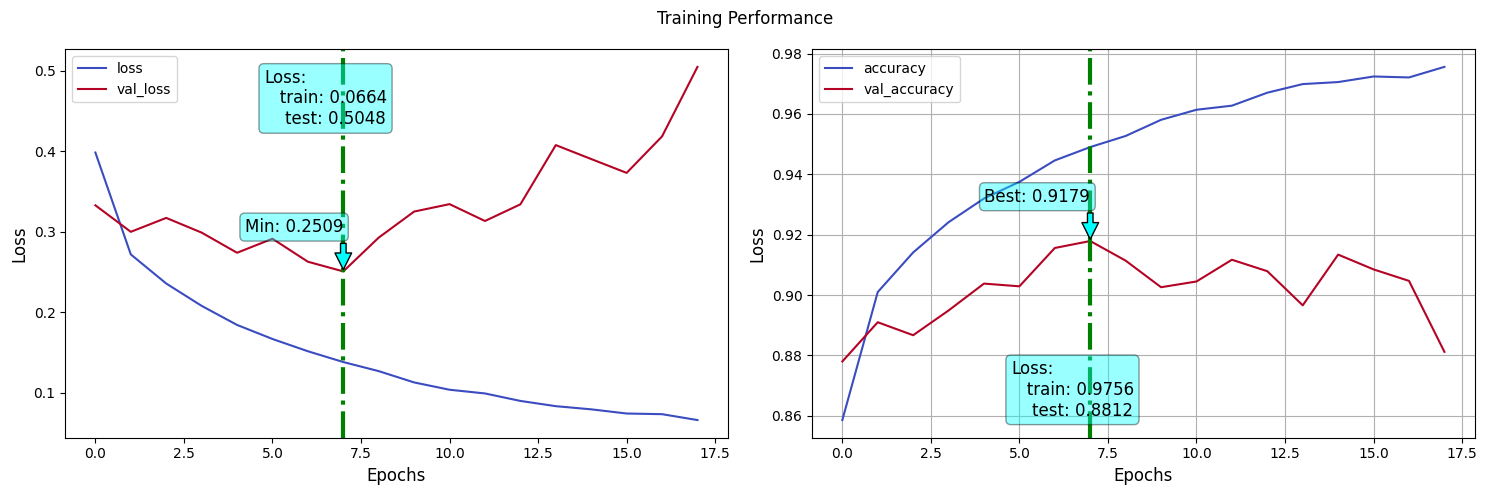

In [24]:
fn_plot_tf_hist(loss_df)

## Evaluating Training Data

In [25]:
y_train = tf.concat([y for x, y in train_ds], axis=0).numpy()
type(y_train), y_train.shape

(numpy.ndarray, (60000,))

In [26]:
y_pred = model.predict(train_ds).argmax(axis=1)
print(f'Accuracy : {accuracy_score(y_train, y_pred) : .5f}')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Accuracy :  0.93642


In [27]:
display(f1_score(y_train, y_pred, average='weighted'))
confusion_matrix(y_train, y_pred)

0.9365370704591292

array([[5019,    1,   29,  153,    9,    0,  788,    0,    1,    0],
       [   4, 5958,    0,   34,    2,    0,    2,    0,    0,    0],
       [  32,    4, 4818,   34,  770,    0,  341,    1,    0,    0],
       [  13,   10,    5, 5875,   53,    0,   43,    1,    0,    0],
       [   3,    2,   48,  166, 5554,    0,  227,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5968,    0,    5,    0,   27],
       [ 150,    2,   66,  151,  163,    1, 5464,    0,    3,    0],
       [   1,    0,    0,    0,    0,   34,    0, 5601,    2,  362],
       [   1,    6,    3,   13,   18,    0,   19,    0, 5940,    0],
       [   0,    0,    0,    1,    0,    5,    0,    5,    1, 5988]])

F1 Score:  0.9365370704591292


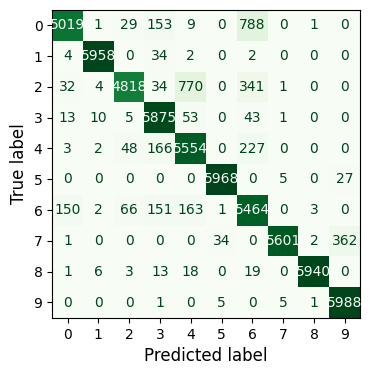

In [28]:
train_cm = confusion_matrix(y_train, y_pred)
print("F1 Score: ", f1_score(y_train, y_pred, average='weighted'))

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax =ax, cmap = 'Greens', colorbar=False);

## Evaluating Validation Dataset

In [29]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()
type(y_test), y_test.shape

(numpy.ndarray, (10000,))

In [30]:
y_pred = model.predict(test_ds).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [31]:
print(f'Accuracy : {accuracy_score(y_test, y_pred) : .5f}')

Accuracy :  0.88120


F1 Score:  0.8815604079311994


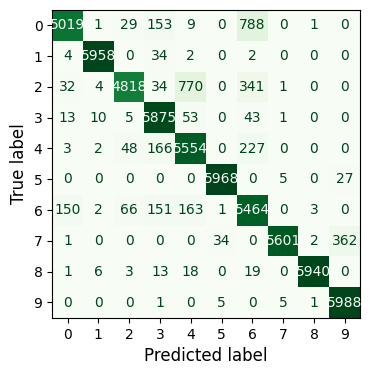

In [32]:
test_cm = confusion_matrix(y_test, y_pred)
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))

disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax =ax, cmap = 'Greens', colorbar=False);

## Save Model

In [33]:
# To save in H5 format:
model.save(os.path.join(modelDir, subDir, 'my_model.keras'))